In [ ]:
!pip install transformers datasets rouge_score evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=efd846fc7c51d7a353c060eb72f5e63ff45eaf20173cd9e21ce395cdf6039f88
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependen

In [ ]:
import os
import re
import string
import torch
import datasets
from datasets import load_from_disk, DatasetDict
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq,AutoModelForSeq2SeqLM,AutoTokenizer
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from evaluate import load
import numpy as np
from nltk.stem import PorterStemmer
from scipy.spatial.distance import cosine
import nltk
import matplotlib.pyplot as plt
import torch.nn.functional as F
import copy
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import evaluate

In [ ]:
import shutil
import pandas as pd

from google.colab import files

In [ ]:
t5_model_name = 't5-base'
data_set_name = 'hotpotqa_dataset'

In [ ]:
# t5_model_name = 'google-t5/t5-base'
max_length = 128

In [ ]:
#!unzip 'hotpotqa_dataset.zip'

In [ ]:
# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
meteor = load('meteor')
rouge_ = evaluate.load("rouge")
bleu_ = evaluate.load("bleu")
meteor_ = evaluate.load("meteor")
perplexity_ = evaluate.load("perplexity")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Initialize the stemmer for stemming words during text normalization
stemmer = PorterStemmer()
# Define a consistent max_length for tokenization
# max_length = 128

# Load the tokenizer and model
# tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
tokenizer = AutoTokenizer.from_pretrained(t5_model_name)
# model = T5ForConditionalGeneration.from_pretrained(t5_model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# 1. Define the custom Seq2SeqDataset class (if needed)
class Seq2SeqDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length=max_length, max_target_length=max_length):
        self.data = data  # The dataset containing the text examples
        self.tokenizer = tokenizer  # The tokenizer for converting text to tokens
        self.max_input_length = max_input_length  # Max length for input sequences
        self.max_target_length = max_target_length  # Max length for target sequences

    def __len__(self):
        return len(self.data)  # Returns the total number of examples in the dataset

    def __getitem__(self, index):
        # Fetch the original and rephrased questions for the given index
        input_text = self.data['original_question'][index]
        target_text = self.data['rephrased_question'][index]

        # Tokenize the input and target texts
        input_ids = self.tokenizer(input_text, padding='max_length', max_length=self.max_input_length, truncation=True, return_tensors='pt').input_ids
        target_ids = self.tokenizer(target_text, padding='max_length', max_length=self.max_target_length, truncation=True, return_tensors='pt').input_ids

        # Return a dictionary with input and target token IDs
        return {'input_ids': input_ids.squeeze(), 'labels': target_ids.squeeze()}

In [ ]:
def load_and_split_dataset(dataset_path, split_ratios=(0.8, 0.1, 0.1)):
    # Load the dataset from the specified path
    dataset = load_from_disk(dataset_path)

    # Check if the dataset already has 'train', 'validation', and 'test' keys
    if all(key in dataset.keys() for key in ['train', 'validation', 'test']):
        print("Dataset already contains 'train', 'validation', and 'test' splits.")
        return dataset  # Return the existing splits

    # If not, perform the splits manually
    print("Splitting the dataset into 'train', 'validation', and 'test' sets.")

    # Split dataset into training and test sets first
    split_dataset = dataset.train_test_split(test_size=split_ratios[2])

    # Further split the training set into train and validation sets
    temp_dataset = split_dataset['train'].train_test_split(test_size=split_ratios[1] / (split_ratios[0] + split_ratios[1]))

    # Combine the splits into a final DatasetDict
    final_splits = DatasetDict({
        'train': temp_dataset['train'],
        'validation': temp_dataset['test'],
        'test': split_dataset['test']
    })

    # Return the split datasets
    return final_splits

In [ ]:
# Ensure consistent tokenization settings across the script
def tokenize_input(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

In [ ]:
# def preprocess_data(tokenizer, dataset, max_input_length=128, max_target_length=128):
#     # This function tokenizes the input and target sequences in the dataset
#     def tokenize_function(examples):
#         # Tokenize the original question
#         model_inputs = tokenizer(
#             examples["original_question"],
#             max_length=max_input_length,
#             truncation=True,
#             padding="max_length"
#         )
#         # Tokenize the rephrased question and store it as labels
#         labels = tokenizer(
#             examples["rephrased_question"],
#             max_length=max_target_length,
#             truncation=True,
#             padding="max_length"
#         )
#         # Replace padding token ids in labels with -100 to ignore them during loss calculation
#         labels["input_ids"] = [
#             [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
#         ]
#         model_inputs["labels"] = labels["input_ids"]
#         return model_inputs

#     # Create a deep copy of the dataset to ensure the original remains unchanged
#     tokenized_dataset = copy.deepcopy(dataset)

#     # Apply tokenization function and remove columns that exist in each split
#     for split in tokenized_dataset:
#         # Get the columns that exist in the current split
#         columns_to_remove = [col for col in ['original_question', 'rephrased_question', 'answer', '__index_level_0__'] if col in tokenized_dataset[split].column_names]

#         # Apply tokenization and remove the existing columns
#         tokenized_dataset[split] = tokenized_dataset[split].map(tokenize_function, batched=True, remove_columns=columns_to_remove)

#     return tokenized_dataset

In [ ]:
def preprocess_data(tokenizer, dataset, max_input_length=128, max_target_length=128, prefix="rewrite: "):
    # This function tokenizes the input and target sequences in the dataset
    def tokenize_function(examples):
        # Prepend the prefix to the original question
        input_text = [prefix + question for question in examples["original_question"]]

        # Tokenize the original question with the prefix
        model_inputs = tokenizer(
            input_text,
            max_length=max_input_length,
            truncation=True,
            padding="max_length"
        )

        # Tokenize the rephrased question and store it as labels
        labels = tokenizer(
            examples["rephrased_question"],
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )

        # Replace padding token ids in labels with -100 to ignore them during loss calculation
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    # Create a deep copy of the dataset to ensure the original remains unchanged
    tokenized_dataset = copy.deepcopy(dataset)

    # Apply tokenization function and remove columns that exist in each split
    for split in tokenized_dataset:
        # Identify the columns that exist in the current split
        columns_to_remove = [col for col in ['original_question', 'rephrased_question', 'answer', '__index_level_0__'] if col in tokenized_dataset[split].column_names]

        # Apply tokenization and remove the existing columns
        tokenized_dataset[split] = tokenized_dataset[split].map(tokenize_function, batched=True, remove_columns=columns_to_remove)

    return tokenized_dataset

In [ ]:
# Text normalization function
def normalize_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove extra whitespaces (e.g., multiple spaces) and trim leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Apply stemming to reduce words to their root form
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    # Return the normalized text
    return text

In [ ]:
# Function to compute normalized edit distance
def compute_normalized_edit_distance(pred, label):
    # Calculate the raw Edit Distance
    raw_edit_distance = nltk.edit_distance(pred, label)

    # Normalize by the length of the longer string
    normalized_edit_distance = raw_edit_distance / max(len(pred), len(label))

    return normalized_edit_distance

In [ ]:
# 4. Define compute_metrics function with proper handling of text-based and embedding-based metrics
def compute_metrics(pred):
    # labels_ids = pred.label_ids
    # pred_ids = pred.predictions.argmax(-1)

    pred_ids, labels_ids = pred
    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]

    # Load the tokenizer to decode the prediction and label IDs back to text
    # tokenizer = T5Tokenizer.from_pretrained("t5-base")

    # Decode the predictions and labels into strings
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels = np.where(labels_ids != -100, labels_ids, tokenizer.pad_token_id)
    labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)


    # labels_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Normalize the decoded strings
    pred_str_norm = [normalize_text(text) for text in pred_str]
    labels_str_norm = [normalize_text(text) for text in labels_str]

    rouge_scores = rouge_.compute(predictions=pred_str_norm, references=labels_str_norm, use_stemmer=True)
    rouge_scores = {k: round(v, 3) for k, v in rouge_scores.items()}

    # Compute BLEU score
    bleu_score = bleu_.compute(predictions=pred_str_norm, references=labels_str_norm)

    # Compute text-based metrics
    # bleu_score = np.mean([sentence_bleu([label], pred) for label, pred in zip(labels_str_norm, pred_str_norm)])

    # rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    # rouge_scores = [rouge_scorer_obj.score(label, pred) for label, pred in zip(labels_str_norm, pred_str_norm)]
    # avg_rouge = {metric: np.mean([score[metric].fmeasure for score in rouge_scores]) for metric in rouge_scores[0].keys()}

    # meteor_scores = meteor_.compute(predictions=pred_str_norm, references=labels_str_norm)

    # meteor_scores = meteor.compute(predictions=pred_str_norm, references=labels_str_norm)

    # edit_distance = np.mean([nltk.edit_distance(pred, label) for pred, label in zip(pred_str_norm, labels_str_norm)])

    # Normalized Edit Distance
    # normalized_edit_distance = np.mean([compute_normalized_edit_distance(pred, label) for pred, label in zip(pred_str_norm, labels_str_norm)])

    # Compute embedding-based metrics
    # Tokenize for embedding-based metrics
    # pred_embeddings = tokenize_input(pred_str)['input_ids']
    # labels_embeddings = tokenize_input(labels_str)['input_ids']

    # Get embeddings for predicted and reference strings using consistent tokenization
    # pred_embeddings = tokenizer(pred_str, padding=True, truncation=True, max_length=max_length, return_tensors='pt')['input_ids']
    # labels_embeddings = tokenizer(labels_str, padding=True, truncation=True, max_length=max_length, return_tensors='pt')['input_ids']

    # Move embeddings to GPU if available
    # if torch.cuda.is_available():
    #     pred_embeddings = pred_embeddings.cuda()
    #     labels_embeddings = labels_embeddings.cuda()

    # Cosine similarity between embeddings
    # cosine_sim_scores = [1 - cosine(pred_embedding.cpu(), label_embedding.cpu()) for pred_embedding, label_embedding in zip(pred_embeddings, labels_embeddings)]
    # avg_cosine_similarity = np.mean(cosine_sim_scores)

    # Compute cosine similarity directly on the GPU using PyTorch
    # print(pred_embeddings.shape)  # Should be [batch_size, sequence_length, embedding_dim]
    # print(labels_embeddings.shape)  # Should match pred_embeddings.shape
    # cosine_sim_scores = F.cosine_similarity(pred_embeddings.float(), labels_embeddings.float(), dim=-1)
    # avg_cosine_similarity = torch.mean(cosine_sim_scores).item()

    # Perplexity (logits-based, not embedding-based)
    # perplexity = torch.exp(torch.mean(pred.predictions))
    # perplexity = perplexity_.compute(predictions=pred_ids)

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in pred_ids]

    # Return the computed metrics as a dictionary
    return {
        # 'cosine_similarity': avg_cosine_similarity,
        "bleu": bleu_score['bleu'],
        # 'bleu': bleu_score,
        # 'rouge1': avg_rouge['rouge1'],
        # 'rougeL': avg_rouge['rougeL'],
        # 'meteor': meteor_scores['meteor'],
        # 'perplexity': perplexity.item(),
        # 'edit_distance': edit_distance,
        # 'normalized_edit_distance': normalized_edit_distance,
        # 'gen_len':np.mean(prediction_lens),
        # 'perplexity': perplexity['perplexity']
        **rouge_scores
    }

In [ ]:
# 5. Set Up the Model and Training Arguments
def setup_model_and_args(model_name="t5-small", output_dir="./results", **kwargs):
    # Load the T5 model and tokenizer
    # model = T5ForConditionalGeneration.from_pretrained(model_name)
    # tokenizer = T5Tokenizer.from_pretrained(model_name)

    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Move model to GPU if available
    # if torch.cuda.is_available():
    #     model.cuda()
    # Default training arguments in a dictionary
    training_args_dict = {
        "output_dir":output_dir,  # Output directory for model checkpoints
        "eval_strategy":'steps',  # Evaluate model at the end of each epoch
        "save_strategy":'steps',  # Save the model every few steps
        "learning_rate":5e-5,  # Learning rate for optimizer
        "warmup_steps":300,
        "per_device_train_batch_size":16,  # Batch size for training
        "per_device_eval_batch_size":16,  # Batch size for evaluation
        "weight_decay":0.01,  # Weight decay to avoid overfitting
        "num_train_epochs":1,  # Number of training epochs
        "fp16":False,#torch.cuda.is_available(),  # Enable mixed precision training if a GPU is available
        "logging_dir":'./logs',  # Directory for storing logs
        "logging_steps":50,  # Log training progress every 10 steps
        "eval_steps":50,  # Evaluate the model every 500 steps
        # "save_steps":100,  # Save model checkpoint every 500 steps
        "save_total_limit":5,
        "load_best_model_at_end":True,  # Load the best model found during training
        # "metric_for_best_model": "cosine_similarity",  # Example: Monitor BLEU score to save the best model
        # "greater_is_better": True,  # Set to False if a lower value is better (e.g., for loss)
        "metric_for_best_model": "eval_loss",
        "greater_is_better": False,
        "predict_with_generate":True
    }

    # Update the dictionary with any provided kwargs
    training_args_dict.update(kwargs)

    # Pass the updated dictionary to TrainingArguments
    # training_args = TrainingArguments(**training_args_dict)
    training_args = Seq2SeqTrainingArguments(**training_args_dict)

    # Return the model, tokenizer, and training arguments
    return model, tokenizer, training_args

In [ ]:
# 6. Initialize Trainer and Data Collator
def initialize_trainer(model, tokenizer, tokenized_dataset, training_args,compute_metrics=None):
    # Define the data collator to dynamically pad the sequences during batching
    # we want to ignore tokenizer pad token in the loss
    label_pad_token_id = -100
    # Data collator
    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        label_pad_token_id=label_pad_token_id,
        # pad_to_multiple_of=8
        )

    # data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    # Initialize the Trainer class with the model, arguments, datasets, tokenizer, and data collator
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],  # Training dataset
        eval_dataset=tokenized_dataset["validation"],  # Validation dataset
        tokenizer=tokenizer,  # Tokenizer to decode the predictions
        data_collator=data_collator,  # Data collator for padding
        compute_metrics=compute_metrics  # Function to compute evaluation metrics
    )

    # Return the initialized Trainer
    return trainer

In [ ]:
# 7. Train the Model and Evaluate
def train_and_evaluate_model(trainer):
    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results

# 8. Save the Model and Tokenizer
def save_model_and_tokenizer(trainer, tokenizer, output_dir="./fine_tuned_t5"):
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

In [ ]:
# Main function to orchestrate the fine-tuning process
def fine_tune_t5(dataset_path, output_dir="./fine_tuned_t5",model_name='t5_small',split_ratios=(0.8, 0.1, 0.1),compute_metrics=None, **training_args):
    dataset_splits = load_and_split_dataset(dataset_path, split_ratios)
    model, tokenizer, training_args = setup_model_and_args(
        model_name=model_name,
        output_dir=output_dir,
        **training_args
    )
    tokenized_dataset = preprocess_data(tokenizer, dataset_splits)
    trainer = initialize_trainer(model, tokenizer, tokenized_dataset, training_args,compute_metrics)

    # Train and Evaluate
    eval_results = train_and_evaluate_model(trainer)
    print(f"Evaluation results: {eval_results}")

    # Save Model and Tokenizer
    save_model_and_tokenizer(trainer, tokenizer, output_dir)

    # Plot losses
    # plot_train_validation_losses(trainer)

    # Plot evaluation metrics
    # plot_evaluation_metrics(trainer)

    return trainer, eval_results

In [ ]:
trainer, results = fine_tune_t5(
        data_set_name,
        output_dir=f"./fine_tuned_{t5_model_name}_{data_set_name}_seqTrainer",
        model_name = t5_model_name,
        split_ratios=(0.8, 0.1, 0.1),
        num_train_epochs=5,
        use_cpu = False,
        learning_rate=3e-5,  # Override the default learning rate
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        compute_metrics=None,
        logging_steps=500,  # Log training progress every 10 steps
        eval_steps=500,  # Evaluate the model every 500 steps
        save_steps=5000,
        # generation_max_length=128,  # Setting the max length for generation
        # generation_num_beams=4      # Optional: beam search setting for generation
    )

Dataset already contains 'train', 'validation', and 'test' splits.


Map:   0%|          | 0/90106 [00:00<?, ? examples/s]

Map:   0%|          | 0/7379 [00:00<?, ? examples/s]

Map:   0%|          | 0/7392 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
500,1.260600,1.045019
1000,0.962300,0.964508
1500,0.901800,0.931222
2000,0.868800,0.915546
2500,0.850300,0.901611
3000,0.819900,0.885313
3500,0.800200,0.876669
4000,0.798800,0.864302
4500,0.780000,0.860461
5000,0.779600,0.849541


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Evaluation results: {'eval_loss': 0.8238270282745361, 'eval_runtime': 68.1313, 'eval_samples_per_second': 108.306, 'eval_steps_per_second': 3.391, 'epoch': 5.0}


In [ ]:
saved_model_folder_final = f"./fine_tuned_{t5_model_name.replace('/','-')}_{data_set_name}_final"
trainer.save_model(saved_model_folder_final)
tokenizer.save_pretrained(saved_model_folder_final)


('./fine_tuned_t5-base_hotpotqa_dataset_final/tokenizer_config.json',
 './fine_tuned_t5-base_hotpotqa_dataset_final/special_tokens_map.json',
 './fine_tuned_t5-base_hotpotqa_dataset_final/spiece.model',
 './fine_tuned_t5-base_hotpotqa_dataset_final/added_tokens.json',
 './fine_tuned_t5-base_hotpotqa_dataset_final/tokenizer.json')

In [ ]:
trainer.save_state()

In [ ]:
shutil.copyfile(os.path.join(f"./fine_tuned_{t5_model_name}_{data_set_name}_seqTrainer",'trainer_state.json'),
                os.path.join(saved_model_folder_final,'trainer_state.json'),
                )

'./fine_tuned_t5-base_hotpotqa_dataset_final/trainer_state.json'

In [ ]:
# import shutil
# shutil.rmtree('/content/fine_tuned_t5-base_combined_dataset_seqTrainer')

In [ ]:

# saved_model_folder_final = f"/content/fine_tuned_google-t5-t5-base_combined/checkpoint-35000"
model_folder_name = saved_model_folder_final
zip_name = f"SFT_model_{data_set_name}_{t5_model_name}_final"
shutil.make_archive(zip_name,'zip',model_folder_name)
files.download(zip_name+'.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#files.download(zip_name)

In [ ]:
def plot_train_validation_losses(trainer, save_path=None):
    train_loss = trainer.state.log_history
    steps = range(len(train_loss))
    train_losses = [x['loss'] for x in train_loss if 'loss' in x]
    eval_losses = [x['eval_loss'] for x in train_loss if 'eval_loss' in x]

    plt.figure(figsize=(12, 6))

    # Plotting both training and validation losses on the same plot
    plt.plot(steps[:len(train_losses)], train_losses, label='Training Loss', color='blue')
    plt.plot(steps[:len(eval_losses)], eval_losses, label='Validation Loss', color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)

    # Show the plot
    plt.show()

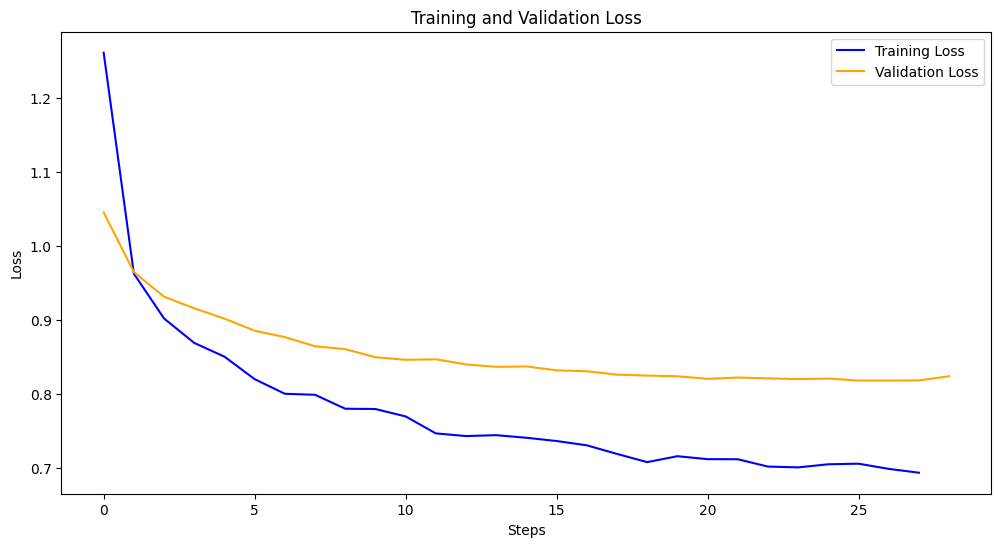

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig_name = f"./{data_set_name}_{t5_model_name}.png"
plot_train_validation_losses(trainer, save_path=fig_name)
files.download(fig_name)

In [ ]:
def create_loss_dataframe(trainer):
    # Initialize lists to store the steps and corresponding losses
    steps = []
    train_losses = []
    eval_losses = []

    # Loop through the log history to extract the relevant data
    for log in trainer.state.log_history:
        if 'loss' in log:
            steps.append(log['step'])
            train_losses.append(log['loss'])
            eval_losses.append(None)  # No evaluation loss for this step
        elif 'eval_loss' in log:
            steps.append(log['step'])
            train_losses.append(None)  # No training loss for this step
            eval_losses.append(log['eval_loss'])

    # Create a DataFrame from the collected data
    df = pd.DataFrame({
        'step': steps,
        'train_loss': train_losses,
        'eval_loss': eval_losses
    })

    # Fill forward the train_loss to align with corresponding eval_loss
    df['train_loss'] = df['train_loss'].fillna(method='ffill')

    return df

# Example usage:
df_losses = create_loss_dataframe(trainer)
print(df_losses.dropna())

     step  train_loss  eval_loss
1     500      1.2606   1.045019
3    1000      0.9623   0.964508
5    1500      0.9018   0.931222
7    2000      0.8688   0.915546
9    2500      0.8503   0.901611
11   3000      0.8199   0.885313
13   3500      0.8002   0.876669
15   4000      0.7988   0.864302
17   4500      0.7800   0.860461
19   5000      0.7796   0.849541
21   5500      0.7696   0.846032
23   6000      0.7467   0.846741
25   6500      0.7431   0.839828
27   7000      0.7443   0.836523
29   7500      0.7408   0.837117
31   8000      0.7364   0.831819
33   8500      0.7306   0.830577
35   9000      0.7190   0.826016
37   9500      0.7079   0.824716
39  10000      0.7159   0.823827
41  10500      0.7119   0.820395
43  11000      0.7118   0.822075
45  11500      0.7019   0.821013
47  12000      0.7008   0.819963
49  12500      0.7050   0.820700
51  13000      0.7058   0.818084
53  13500      0.6988   0.818077
55  14000      0.6936   0.818260
56  14080      0.6936   0.823827


<ipython-input-30-00782ce8bd33>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['train_loss'] = df['train_loss'].fillna(method='ffill')


In [ ]:
loss_df_file_name = f"{data_set_name}_{t5_model_name}.csv"
df_losses.dropna().to_csv(loss_df_file_name,index=False)
files.download(loss_df_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from google.colab import runtime

# runtime.unassign()

In [ ]:
while True:
  pass